In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [199]:
def compare_matches(padded_img1, padded_img2, center1, center2, patch_half_size, debug=False):
    # indexing for slicing patch frim images
    i1_start = center1[1]
    i1_end = center1[1]+2*patch_half_size+1
    j1_start = center1[0]
    j1_end = center1[0]+2*patch_half_size+1
    
    i2_start = center2[1]
    i2_end = center2[1]+2*patch_half_size+1
    j2_start = center2[0]
    j2_end = center2[0]+2*patch_half_size+1
    
    if debug:
        print(padded_img1)
        print(padded_img2)

    patch_1 = padded_img1[i1_start:i1_end, j1_start:j1_end]
    patch_2 = padded_img2[i2_start:i2_end, j2_start:j2_end]

    if debug:
        print(patch_1)
        print(patch_2)

    mask = np.logical_and(patch_1 >= 0,patch_2 >= 0)
    patch_1 = patch_1[mask]
    patch_2 = patch_2[mask]

    return np.sum((patch_1-patch_2)**2)/patch_1.size
        
def patch_match(img1, img2, patch_size=11):
    height, width, ch = img1.shape
    # create random ofset with the shape h*w for dy and dx
    match_x = np.random.randint(0, width, size=(height,width))
    match_y = np.random.randint(0, height, size=(height,width))
    
    patch_half_size = patch_size // 2
    padded_img1 = -1*np.ones([height+2*patch_half_size, width+2*patch_half_size, ch], dtype=int)
    padded_img2 = -1*np.ones([height+2*patch_half_size, width+2*patch_half_size, ch], dtype=int)
    padded_img1[patch_half_size:patch_half_size+height, patch_half_size:patch_half_size+width] = img1
    padded_img2[patch_half_size:patch_half_size+height, patch_half_size:patch_half_size+width] = img2
    
    iteration = 0
    
    while iteration<5:
        # choose direction of propagation
        if iteration % 2 == 0:
            iter_i = range(height)
            iter_j = range(width)
            edge_i = 0
            edge_j = 0
            delta = -1
        else:
            iter_i = range(height-1, -1, -1)
            iter_j = range(width-1, -1, -1)
            edge_i = height-1
            edge_j = width-1
            delta = 1
           
        # propagate
        # y
        for i in iter_i:
            # x
            for j in iter_j:
                
                current_x = match_x[i][j]
                current_y = match_y[i][j]
                candidates = [[current_x, current_y]]
                if i != edge_i:
                    candidates.append([match_x[i+delta][j], match_y[i+delta][j]])
                if j != edge_j:
                    candidates.append([match_x[i][j+delta], match_y[i][j+delta]])
                if len(candidates) != 1:
                    distances = [compare_matches(padded_img1, padded_img2, \
                                                 [j, i], candidates[k], patch_half_size) for k in range(len(candidates))]
                    min_dist_index = np.argmin(distances)
                    min_dist = distances[min_dist_index]
                    top_candidate = candidates[min_dist_index]

                    match_x[i][j] = top_candidate[0]
                    match_y[i][j] = top_candidate[1]        

                # random search around current position
                wa_x = width // 2
                wa_y = height // 2
                
                while wa_x >= 1 and wa_y >= 1:
                    deltas = [-1,1] 
                    candidate_x = current_x + wa_x * deltas[np.random.randint(0,2)]
                    candidate_y = current_y + wa_y * deltas[np.random.randint(0,2)]
                    
                    candidate_x = candidate_x % width
                    candidate_y = candidate_y % height
                    
                    distance = compare_matches(padded_img1, padded_img2, \
                                               [j, i], [candidate_x, candidate_y], patch_half_size)
                    if distance < min_dist:
                        match_x[i][j] = candidate_x
                        match_y[i][j] = candidate_y
                        min_dist = distance
                    
                    wa_x = wa_x // 2
                    wa_y = wa_y // 2
        
        iteration += 1
    
    ref_i = [np.ones(width, dtype=int)*i for i in range(height)]
    ref_j = [list(range(width)) for i in range(height)]
    
        
    return match_x-ref_j, match_y-ref_i

In [200]:
a = np.array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]] ,
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]]])

b = np.array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]] ,
             [[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]]])
print(a)

[[[0 1 2]
  [3 4 5]
  [6 7 8]]

 [[0 1 2]
  [3 4 5]
  [6 7 8]]

 [[0 1 2]
  [3 4 5]
  [6 7 8]]]


In [201]:
patch_match(a,b,3)

(array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), array([[ 1,  1,  2],
        [ 0, -1,  1],
        [-1, -2,  0]]))

In [202]:
frame_1 = cv2.resize(cv2.cvtColor(cv2.imread("./v001.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_5 = cv2.resize(cv2.cvtColor(cv2.imread("./v005.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_50 = cv2.resize(cv2.cvtColor(cv2.imread("./v050.jpg"), cv2.COLOR_BGR2RGB),(320,180))
frame_100 = cv2.resize(cv2.cvtColor(cv2.imread("./v100.jpg"), cv2.COLOR_BGR2RGB),(320,180))


# Frames 1 vs 50

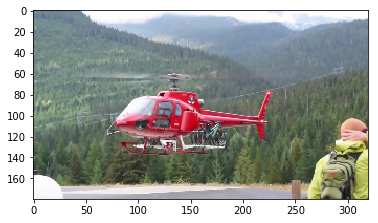

In [203]:
plt.imshow(frame_1)

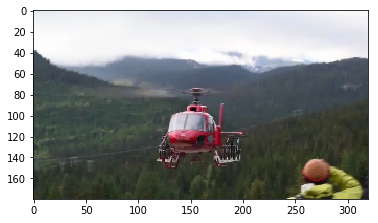

In [204]:
plt.imshow(frame_50)

In [208]:
%%time
dx, dy = patch_match(frame_1, frame_50, patch_size=15)

Wall time: 1min 12s


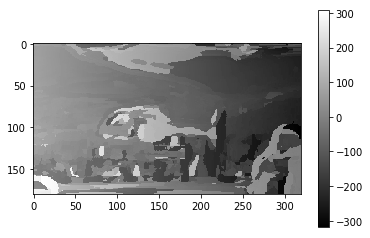

In [209]:
plt.imshow(dx, cmap="gray")
plt.colorbar()

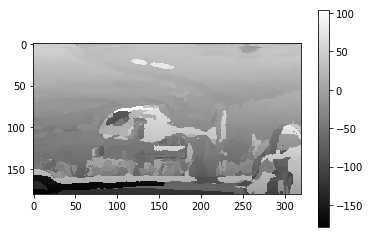

In [210]:
plt.imshow(dy, cmap="gray")
plt.colorbar()

# Frames 1 vs 5

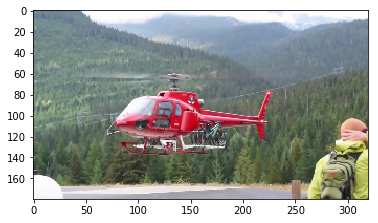

In [118]:
plt.imshow(frame_1)

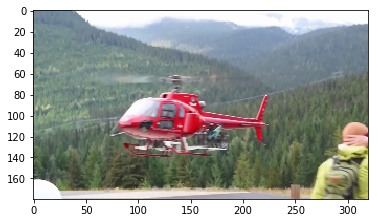

In [119]:
plt.imshow(frame_5)

In [211]:
%%time
dx, dy = patch_match(frame_1, frame_5, patch_size=15)

Wall time: 1min 13s


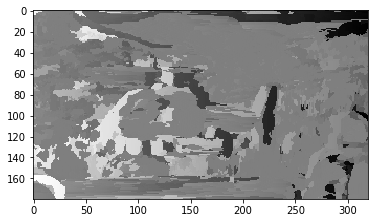

In [212]:
plt.imshow(dx, cmap="gray")

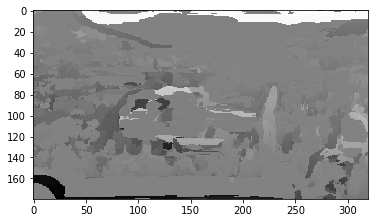

In [213]:
plt.imshow(dy, cmap="gray")

# Baseline test 

In [214]:
try_1 = cv2.cvtColor(cv2.imread("./1.png"), cv2.COLOR_BGR2RGB)
try_5 = cv2.cvtColor(cv2.imread("./2.png"), cv2.COLOR_BGR2RGB)

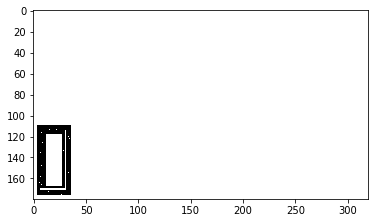

In [215]:
plt.imshow(try_1)

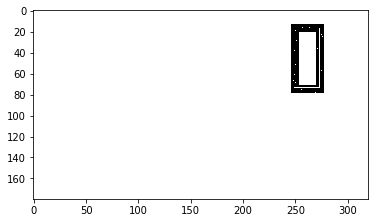

In [216]:
plt.imshow(try_5)

In [223]:
%%time
dx, dy = patch_match(try_1, try_5, patch_size=13)

Wall time: 1min 10s


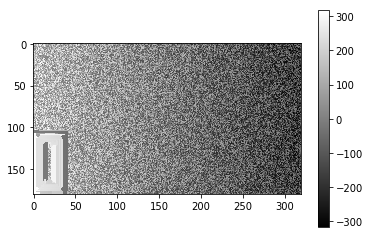

In [224]:
plt.imshow(dx, cmap="gray")
plt.colorbar()

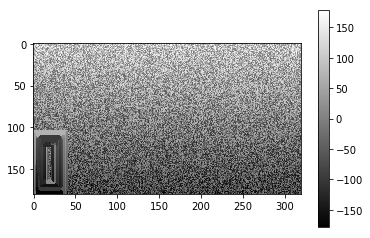

In [225]:
plt.imshow(dy, cmap="gray")
plt.colorbar()